In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
from pydantic import BaseModel, Field
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load results

In [2]:
# pydantic model

class PreprocessingSteps(BaseModel):
    transformers: Tuple[
        Tuple[PCA, StandardScaler, np.ndarray, np.ndarray],
        Tuple[float, float]
    ] = Field(
        ..., 
        description="Preprocessing steps including PCA, StandardScaler, and arrays"
    )

    class Config:
        arbitrary_types_allowed = True
        json_encoders = {
            np.ndarray: lambda v: v.tolist(),
            PCA: lambda v: str(v),
            StandardScaler: lambda v: str(v)
        }


In [3]:
def load_data(dataset: str) -> dict:
    """
    Load data from pickle files for a specific dataset.
    
    Args:
        dataset (str): Name of the dataset or specific subdirectory
    
    Returns:
        dict: A dictionary with full file paths as keys and loaded data as values
    """
    base_dir = "../results/datasets/real_world_data"
    full_path = os.path.join(base_dir, dataset)
    
    data_dict = {}
    
    # Walk through the directory tree starting from the specified dataset path
    for root, dirs, files in os.walk(full_path):
        for file in files:
            # Check if the file is a pickle file
            if file.endswith('.pkl') or file.endswith('.p'):
                full_file_path = os.path.join(root, file)
                
                try:
                    # Load the pickle file
                    with open(full_file_path, "rb") as f:
                        data = pickle.load(f)
                    
                    # Store in the dictionary with full path as key
                    data_dict[full_file_path] = data
                
                except (IOError, pickle.UnpicklingError) as e:
                    print(f"Error loading {full_file_path}: {e}")
    
    return data_dict

# functions to collate the data

In [40]:
# get the explained variance objectives for train and validation

def extract_explained_variance(data: list[list[PreprocessingSteps]]) -> np.array:

    explained_variance = []
    
    for j in range(len(data)):
        
        data_run = [data[j][i][-1] for i in range(len(data[j]))]
        explained_variance.append(data_run)

    return np.array(explained_variance)

# visualise

In [19]:
def plot_percentiles(data):

    # Compute percentiles along the first axis (runs)
    p20 = np.percentile(data, 20, axis=0)
    p50 = np.percentile(data, 50, axis=0)
    p80 = np.percentile(data, 80, axis=0)
    
    # Create x-axis (time steps)
    x = np.arange(data.shape[1])
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot for each dimension of the last axis
    colors = ['blue', 'red']
    labels = ['Dimension 1', 'Dimension 2']
    
    for dim in range(2):
        plt.fill_between(x, p20[:, dim], p80[:, dim], alpha=0.2, color=colors[dim])
        plt.plot(x, p50[:, dim], color=colors[dim], label=f'{labels[dim]} Median')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Percentile Visualization')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [26]:
data_dictionary = load_data("wine")

In [32]:
data_dictionary.keys()

dict_keys(['../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/0.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/16.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/18.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/9.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/22.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/11.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/17.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/12.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/28.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/2.p', '../results/datasets/real_world_data/wine/activation=relu/partial_contrib=True/14.p', '../results/datasets/real_world_data/wine/acti

In [27]:
partial_contrib_data = [value for key, value in data_dictionary.items() if 'True' in key]
full_contrib_data = [value for key, value in data_dictionary.items() if 'False' in key]

In [41]:
explained_variance_partial = extract_explained_variance(partial_contrib_data)

In [42]:
explained_variance_full = extract_explained_variance(full_contrib_data)

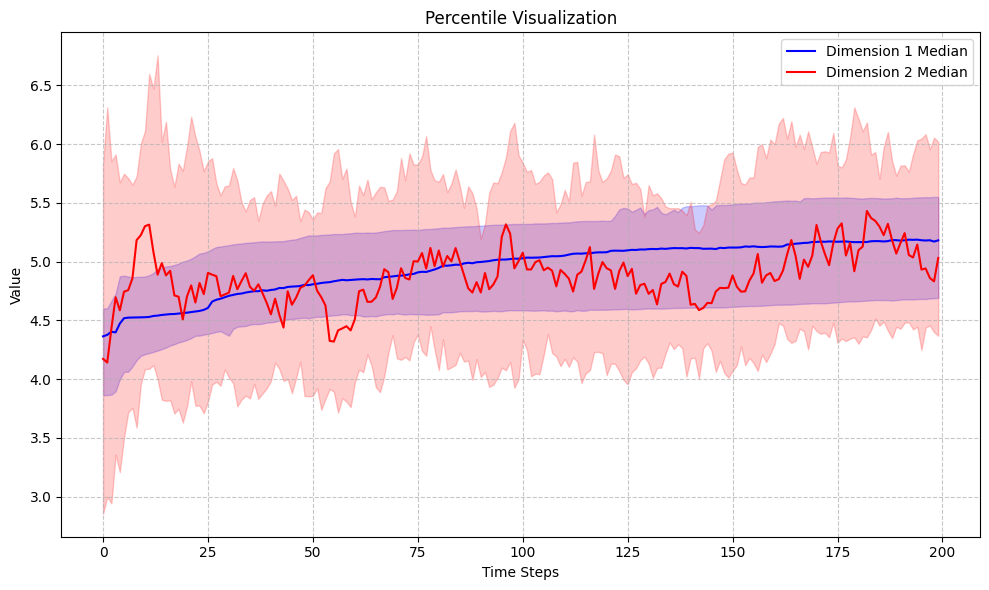

In [43]:
plot_percentiles(explained_variance_partial)

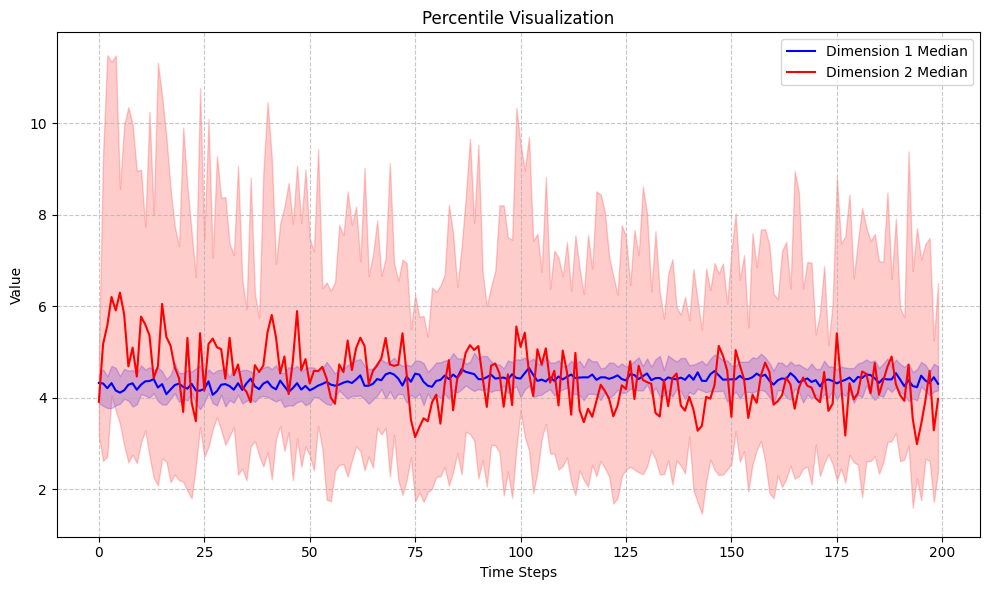

In [44]:
plot_percentiles(explained_variance_full)